# Grad-CAM++

In [92]:
import cv2
import torch
import numpy as np
from torchvision.transforms import ToPILImage
from PIL import Image, ImageChops
import matplotlib.pyplot as plt
from collections import OrderedDict

from blazeface import FaceExtractor, BlazeFace
from architectures import EBAttentionv2
from architectures.EBAttentionv2 import FeatureExtractor
from isplutils import utils

from pytorch_grad_cam import GradCAM, \
    ScoreCAM, \
    GradCAMPlusPlus, \
    AblationCAM, \
    XGradCAM, \
    EigenCAM, \
    EigenGradCAM, \
    LayerCAM, \
    FullGrad

from pytorch_grad_cam import GuidedBackpropReLUModel
from pytorch_grad_cam.utils.image import show_cam_on_image, \
    deprocess_image, \
    preprocess_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget

## Parameters

In [93]:
model_name = "EfficientNetCA"

use_cuda = torch.cuda.is_available()
method = "gradcam++"
aug_smooth = False
eigen_smooth = False

In [94]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
face_policy = 'scale'
face_size = 224

In [95]:
methods = {"gradcam": GradCAM,
    "scorecam": ScoreCAM,
    "gradcam++": GradCAMPlusPlus,
    "ablationcam": AblationCAM,
    "xgradcam": XGradCAM,
    "eigencam": EigenCAM,
    "eigengradcam": EigenGradCAM,
    "layercam": LayerCAM,
    "fullgrad": FullGrad}

## Initialization

In [96]:
model_path = "./weights/binclass/net-EfficientNetCA_traindb-ff-c23-720-140-140_face-scale_size-224_seed-41/bestval.pth"

# Load net
net_class = getattr(EBAttentionv2, model_name)

print('Loading model...')
state_tmp = torch.load(model_path, map_location='cpu')
if 'net' not in state_tmp.keys():
    state = OrderedDict({'net': OrderedDict()})
    [state['net'].update({'model.{}'.format(k): v}) for k, v in state_tmp.items()]
else:
    state = state_tmp

net: FeatureExtractor = net_class().eval().to(0)

incomp_keys = net.load_state_dict(state['net'], strict=True)

Loading model...
Loaded pretrained weights for efficientnet-b4


In [97]:
transf = utils.get_transformer(face_policy, face_size, net.get_normalizer(), train=False)

In [98]:
facedet = BlazeFace().to(device)
facedet.load_weights("./blazeface/blazeface.pth")
facedet.load_anchors("./blazeface/anchors.npy")
face_extractor = FaceExtractor(facedet=facedet)

## Load images

In [99]:
im_real = Image.open('./True01.jpg')
im_fake = Image.open('./False01.jpg')

Text(0.5, 1.0, 'FAKE')

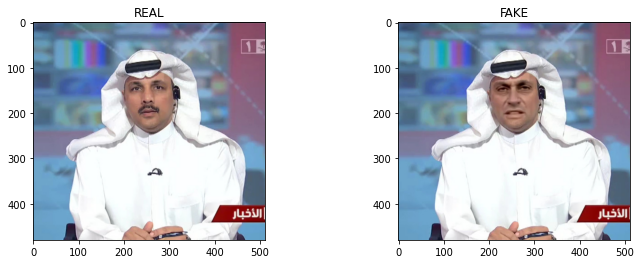

In [100]:
fig,ax = plt.subplots(1,2,figsize=(12,4))

ax[0].imshow(im_real)
ax[0].set_title('REAL')

ax[1].imshow(im_fake)
ax[1].set_title('FAKE')

## Extract faces


In [101]:
im_real_faces = face_extractor.process_image(img=im_real)
im_fake_faces = face_extractor.process_image(img=im_fake)

In [102]:
im_real_face = im_real_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace
im_fake_face = im_fake_faces['faces'][0] # take the face with the highest confidence score found by BlazeFace

In [103]:
print(im_fake_face.shape)

(201, 176, 3)


Text(0.5, 1.0, 'FAKE')

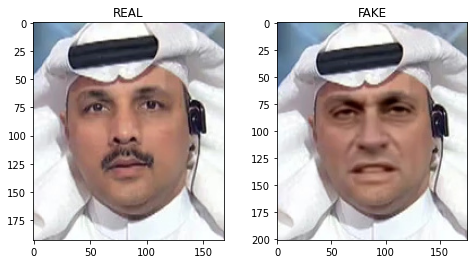

In [104]:
fig,ax = plt.subplots(1,2,figsize=(8,4))

ax[0].imshow(im_real_face)
ax[0].set_title('REAL')

ax[1].imshow(im_fake_face)
ax[1].set_title('FAKE')

## Predict Score

In [105]:
faces_t = torch.stack( [ transf(image=im)['image'] for im in [im_real_face,im_fake_face] ] )

with torch.no_grad():
    faces_pred = torch.sigmoid(net(faces_t.to(device))).cpu().numpy().flatten()

In [106]:
"""
Print scores.
A score close to 0 predicts REAL. A score close to 1 predicts FAKE.
"""
print('Score for REAL face: {:.4f}'.format(faces_pred[0]))
print('Score for FAKE face: {:.4f}'.format(faces_pred[1]))

Score for REAL face: 0.0432
Score for FAKE face: 0.9549


## CAM

In [107]:
target_layers = [net.efficientnet._blocks[-1]]

rgb_img = np.float32(im_fake_face) / 255
input_tensor = preprocess_image(
    im_real_face,
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225])

In [108]:
targets = None
print(type(im_fake_face))

<class 'numpy.ndarray'>


In [109]:
cam_algorithm = methods[method]
with cam_algorithm(model= net, target_layers=target_layers, use_cuda= use_cuda) as cam:

    # AblationCAM and ScoreCAM have batched implementations.
    # You can override the internal batch size for faster computation.
    cam.batch_size = 32
    grayscale_cam = cam(input_tensor=input_tensor,
                        targets=targets,
                        aug_smooth= aug_smooth,
                        eigen_smooth= eigen_smooth)

    # Here grayscale_cam has only one image in the batch
    grayscale_cam = grayscale_cam[0, :]

    cam_image = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    # cam_image is RGB encoded whereas "cv2.imwrite" requires BGR encoding.
    cam_image = cv2.cvtColor(cam_image, cv2.COLOR_RGB2BGR)

gb_model = GuidedBackpropReLUModel(model= net, use_cuda=use_cuda)
gb = gb_model(input_tensor, target_category=None)

cam_mask = cv2.merge([grayscale_cam, grayscale_cam, grayscale_cam])
cam_gb = deprocess_image(cam_mask * gb)
gb = deprocess_image(gb)

ValueError: operands could not be broadcast together with shapes (193,169,3) (201,176,3) 